In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import joblib


In [7]:

df = pd.read_csv(r"D:\final data_set.zip")
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (42372, 1036)


,1/1/2014,1/2/2014,1/3/2014,1/4/2014,1/5/2014,1/6/2014,1/7/2014,1/8/2014,1/9/2014,1/10/2014,...,10/24/2016,10/25/2016,10/26/2016,10/27/2016,10/28/2016,10/29/2016,10/30/2016,10/31/2016,CONS_NO,FLAG
0,0.0,0.0,0.01,0.0,0.0,0.00,0.00,0.00,0.00,0.00,...,0.02,0.06,0.58,0.89,0.35,0.38,0.70,0.25,0387DD8A07E07FDA6271170F86AD9151,1
1,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,...,17.13,14.32,16.37,26.33,19.06,17.38,13.94,14.14,01D6177B5D4FFE0CABA9EF17DAFC2B84,1
2,0.0,0.0,0.00,0.0,0.0,4.98,9.87,11.29,13.44,11.34,...,4.29,1.43,2.22,2.41,3.48,2.89,1.88,1.16,4B75AC4F2D8434CFF62DB64D0BB43103,1
3,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,...,20.98,18.47,15.50,14.80,19.28,16.10,17.51,16.67,B32AC8CC6D5D805AC053557AB05F5343,1
4,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,...,0.61,1.33,0.55,1.62,1.53,2.10,1.16,2.13,EDFC78B07BA2908B3395C4EB2304665E,1


In [8]:
X = df.select_dtypes(include=[np.number]).values

X = np.nan_to_num(X, nan=np.nanmean(X))

print("All numeric features, shape =", X.shape)


All numeric features, shape = (42372, 1035)


In [9]:
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])


Train size: 33897
Test size: 8475


In [11]:
iso = IsolationForest(
    n_estimators=300,
    contamination=0.1,   # assumes ~10% are anomalous
    random_state=42
)

iso.fit(X_train)
print(" Model training completed.")


 Model training completed.


In [12]:
y_train_pred = iso.predict(X_train)
y_test_pred = iso.predict(X_test)

print("Train prediction counts:\n", pd.Series(y_train_pred).value_counts())
print("\nTest prediction counts:\n", pd.Series(y_test_pred).value_counts())


Train prediction counts:
  1    30507
-1     3390
Name: count, dtype: int64

Test prediction counts:
  1    7609
-1     866
Name: count, dtype: int64


In [13]:
y_true = np.ones(len(X_test))
y_true[:int(0.1 * len(y_true))] = -1  

y_pred = y_test_pred

acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
print("Testing Accuracy (simulated):", round(acc * 100, 2), "%")
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=3))


Testing Accuracy (simulated): 81.72 %

Confusion Matrix:
 [[  82  765]
 [ 784 6844]]

Classification Report:
               precision    recall  f1-score   support

        -1.0      0.095     0.097     0.096       847
         1.0      0.899     0.897     0.898      7628

    accuracy                          0.817      8475
   macro avg      0.497     0.497     0.497      8475
weighted avg      0.819     0.817     0.818      8475



In [14]:
scores = iso.decision_function(X)
preds = iso.predict(X)

df["anomaly_flag"] = preds
df["anomaly_score"] = scores

print("Results added to dataset.")
print(df.head())


Results added to dataset.
   1/1/2014  1/2/2014  1/3/2014  1/4/2014  1/5/2014  1/6/2014  1/7/2014  \
0       0.0       0.0      0.01       0.0       0.0      0.00      0.00   
1       0.0       0.0      0.00       0.0       0.0      0.00      0.00   
2       0.0       0.0      0.00       0.0       0.0      4.98      9.87   
3       0.0       0.0      0.00       0.0       0.0      0.00      0.00   
4       0.0       0.0      0.00       0.0       0.0      0.00      0.00   

   1/8/2014  1/9/2014  1/10/2014  ...  10/26/2016  10/27/2016  10/28/2016  \
0      0.00      0.00       0.00  ...        0.58        0.89        0.35   
1      0.00      0.00       0.00  ...       16.37       26.33       19.06   
2     11.29     13.44      11.34  ...        2.22        2.41        3.48   
3      0.00      0.00       0.00  ...       15.50       14.80       19.28   
4      0.00      0.00       0.00  ...        0.55        1.62        1.53   

   10/29/2016  10/30/2016  10/31/2016                       

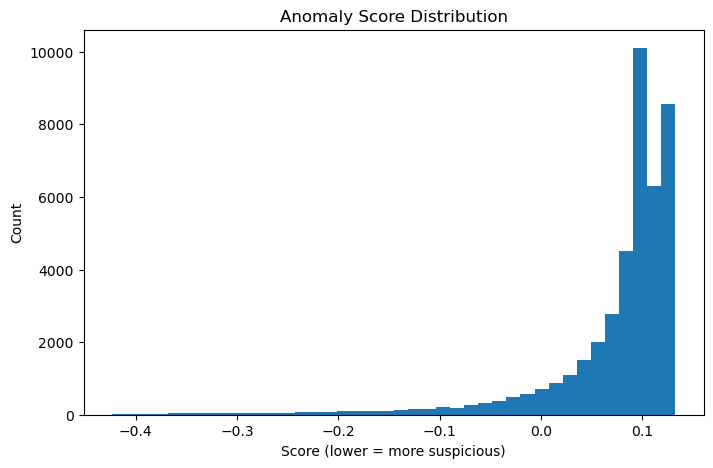

In [15]:
plt.figure(figsize=(8,5))
plt.hist(df["anomaly_score"], bins=40)
plt.title("Anomaly Score Distribution")
plt.xlabel("Score (lower = more suspicious)")
plt.ylabel("Count")
plt.show()


In [16]:
joblib.dump(iso, "theft_detection_model.joblib")
df.to_csv("theft_anomaly_results.csv", index=False)

print("Model saved as 'theft_detection_model.joblib'")
print("Results saved as 'theft_anomaly_results.csv'")


Model saved as 'theft_detection_model.joblib'
Results saved as 'theft_anomaly_results.csv'


In [17]:
new_data = np.array([[5.1, 6.0, 7.2, 6.3, 8.1, 9.0, 7.5, 6.8, 7.9, 8.2]])
prediction = iso.predict(new_data)
score = iso.decision_function(new_data)

if prediction[0] == -1:
    print("🚨 Theft likely detected! (anomalous usage pattern)")
else:
    print("✅ Normal usage pattern")

print("Anomaly score:", score[0])


ValueError: X has 10 features, but IsolationForest is expecting 1035 features as input.